# GPU check and setup

In [ ]:
! nvidia-smi

Thu Aug 18 12:08:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: Tesla T4


#Pips and imports



In [ ]:
!pip install --quiet transformers
!pip install --quiet bert-score 
!pip install --quiet sacremoses
!pip install --quiet ohmeow-blurr 
!pip install  --quiet textwrap3 

In [ ]:
import  torch
from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, ItemGetter, ColSplitter, RandomSplitter,TrainTestSplitter
from fastai.data.core import DataLoaders
from fastai.imports import *
from fastai.learner import *
from fastai.torch_core import *
from fastai.torch_imports import *
from fastcore.all import *
from blurr.text.data.seq2seq.core import Seq2SeqBatchTokenizeTransform, Seq2SeqTextBlock, default_text_gen_kwargs
from blurr.text.modeling.core import BaseModelCallback, BaseModelWrapper, Blearner
from blurr.text.modeling.seq2seq.core import Seq2SeqMetricsCallback, blurr_seq2seq_splitter
from blurr.text.utils import get_hf_objects
from blurr.utils import PreCalculatedCrossEntropyLoss
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, ranger, OptimWrapper, params
from fastcore.test import *
from textwrap3 import wrap
from transformers import BartForConditionalGeneration
from blurr.utils import print_versions

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
print_versions("torch fastai transformers")

torch: 1.12.1+cu113
fastai: 2.7.9
transformers: 4.21.1


#Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path=r"/content/drive/MyDrive/Colab_Notebooks/datasets/smscorpus/val.json"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Read data

In [ ]:
with open(path) as jfile:
  data = json.load(jfile)

In [ ]:
my_dict = {"id":[],"dialogue":[],"summary":[]}
for entry in data[:20]:
  my_dict["id"].append(entry['id'])
  my_dict["dialogue"].append(entry['dialogue'])
  my_dict["summary"].append(entry['summary'])  

In [ ]:
df = pd.DataFrame(my_dict)

In [ ]:
#basic cleaning 
noise=["\n","\r",";-","😎","❤️","😄","😁","(^o^)","😊","👍","😃","🤔","🙄","😒","😒","😜","😪"," 😪","(＾▽＾)","<file_gif>","🙃","🤓","😂","💕","<file_video>",":D","💪","🥕","😝"]
for i in range(len(noise)):
  df['dialogue']=df['dialogue'].map(lambda x : str(x).replace(noise[i],""))

In [ ]:
df.head()

,id,dialogue,summary
0,13817023,"A: Hi Tom, are you busy tomorrow’s afternoon?B: I’m pretty sure I am. What’s up?A: Can you go with me to the animal shelter?.B: What do you want to do?A: I want to get a puppy for my son.B: That will make him so happy.A: Yeah, we’ve discussed it many times. I think he’s ready now.B: That’s good. Raising a dog is a tough issue. Like having a baby ) A: I'll get him one of those little dogs.B: One that won't grow up too big)A: And eat too much))B: Do you know which one he would like?A: Oh, yes, I took him there last Monday. He showed me one that he really liked.B: I bet you had to drag him aw...",A will go to the animal shelter tomorrow to get a puppy for her son. They already visited the shelter last Monday and the son chose the puppy.
1,13716628,"Emma: I’ve just fallen in love with this advent calendar! Awesome! I wanna one for my kids!Rob: I used to get one every year as a child! Loved them! Emma: Yeah, i remember! they were filled with chocolates!Lauren: they are different these days! much more sophisticated! Haha!Rob: yeah, they can be fabric/ wooden, shop bought/ homemade, filled with various stuffEmma: what do you fit inside?Lauren: small toys, Christmas decorations, creative stuff, hair bands & clips, stickers, pencils & rubbers, small puzzles, sweetsEmma: WOW! That’s brill! XLauren: i add one more very special thing as well-...","Emma and Rob love the advent calendar. Lauren fits inside calendar various items, for instance, small toys and Christmas decorations. Her children are excited whenever they get the calendar."
2,13829420,Jackie: Madison is pregnantJackie: but she doesn't wanna talk about itIggy: whyJackie: I don't know why because she doesn't wanna talk about itIggy: okJackie: I wanted to prepare you for it because people get super excited and ask lots of questionsJackie: and she looked way more anxious than excitedIggy: she's probably worrying about itIggy: she's taking every commitment really seriouslyJackie: it could be money problems or relationship problemsIggy: or maybe she wants an abortionJackie: it could be all of the aboveIggy: but you know what?Iggy: once my friend was pregnant and I couldn't br...,Madison is pregnant but she doesn't want to talk about it. Patricia Stevens got married and she thought she was pregnant.
3,13819648,"Marla: <file_photo>Marla: look what I found under my bedKiki: lolTamara: is that someone's underwear?Marla: it certainly isn't mine, my ass is big but it isn't hugeKiki: it looks like male underwearTamara: not necessarily, maybe some butch had fun in your room while you were goneMarla: ok but how can you leave your underwear after hooking up? wtf is wrong with peopleKiki: she or he could be too wasted to noticeTamara: or maybe someone put their pants there to piss you offMarla: that makes no senseMarla: it's so fucking childishKiki: if it's childish then it must have been your sister's ide...",Marla found a pair of boxers under her bed.
4,13728448,Robert: Hey give me the address of this music shop you mentioned beforeRobert: I have to buy guitar cableFred: <file_other>Fred: Catch it on google mapsRobert: thx m8Fred: ur welcome,Robert wants Fred to send him the address of the music shop as he needs to buy guitar cable.


#Downloading the required objects

In [ ]:
pretrained_model_name = "philschmid/bart-large-cnn-samsum"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=BartForConditionalGeneration)
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [ ]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization')
text_gen_kwargs

{'max_length': 142,
 'min_length': 56,
 'do_sample': False,
 'early_stopping': True,
 'num_beams': 4,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'typical_p': 1.0,
 'repetition_penalty': 1.0,
 'bad_words_ids': None,
 'bos_token_id': 0,
 'pad_token_id': 1,
 'eos_token_id': 2,
 'length_penalty': 2.0,
 'no_repeat_ngram_size': 3,
 'encoder_no_repeat_ngram_size': 0,
 'num_return_sequences': 1,
 'decoder_start_token_id': 2,
 'use_cache': True,
 'num_beam_groups': 1,
 'diversity_penalty': 0.0,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'return_dict_in_generate': False,
 'forced_bos_token_id': 0,
 'forced_eos_token_id': 2,
 'remove_invalid_values': False,
 'exponential_decay_length_penalty': None}

#Data block for Data-loader

In [ ]:
hf_batch_tfm = Seq2SeqBatchTokenizeTransform(
    hf_arch, hf_config, hf_tokenizer, hf_model, max_length=50, max_tgt_length=20,
     min_length=10,
     text_gen_kwargs=text_gen_kwargs
)

In [ ]:
blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=hf_batch_tfm), noop)

In [ ]:
dblock = DataBlock(blocks=blocks,
                   get_x=ColReader('dialogue'),
                   get_y=ColReader('summary'),
                   splitter=TrainTestSplitter(test_size=0.2, train_size=0.8, random_state=707, stratify=None,  shuffle=True))

In [ ]:
dls = dblock.dataloaders(df, bs=2)

In [ ]:
len(dls.train.items), len(dls.valid.items)

(16, 4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"<s> Marla: <file_photo>Marla: look what I found under my bedKiki: lolTamara: is that someone's underwear?Marla: it certainly isn't mine, my ass is big but it isn't</s>",Marla found a pair of boxers under her bed.
1,"<s> Emma: I’ve just fallen in love with this advent calendar! Awesome! I wanna one for my kids!Rob: I used to get one every year as a child! Loved them! Emma: Yeah, i remember!</s>","Emma and Rob love the advent calendar. Lauren fits inside calendar various items, for instance, small toys and Christmas decorations. Her children are excited whenever they get the calendar."


# Training setup

In [ ]:
model = BaseModelWrapper(hf_model)

In [ ]:
learn_cbs = [BaseModelCallback]

In [ ]:
seq2seq_metrics = {
        'bertscore': {
            'compute_kwargs': { 'lang': 'en' },
            'returns': ["precision", "recall", "f1"]
        }
    }

In [ ]:
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

# Learner

Class to handle training loop.

In [ ]:
learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(blurr_seq2seq_splitter, arch=hf_arch)).to_fp16()

In [ ]:
learn.create_opt() 

In [ ]:
learn.freeze()

In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 2 x 50)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 36 x 1024       
Embedding                                 51470336   False     
Embedding                                 51470336   False     
____________________________________________________________________________
                     2 x 1024            
BartLearnedPositionalEmbedding                      1050624    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
LayerNorm                                 2048       True      
GELUActivation                                                 
____________________________________________________________________________
                     2 x 50 x 4096       
Linear                         

#Finding optimistic learning rate


SuggestedLRs(minimum=0.00036307806149125097, steep=1.0964781722577754e-06, valley=0.00013182566908653826, slide=0.00019054606673307717)

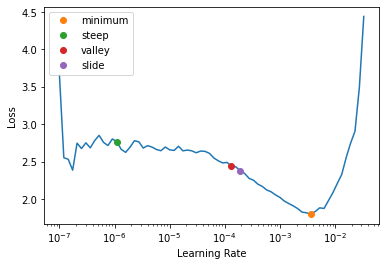

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-3, cbs=fit_cbs)

epoch,train_loss,valid_loss,bertscore_precision,bertscore_recall,bertscore_f1,time
0,1.419172,2.386627,0.835977,0.900849,0.867039,00:10
1,1.184879,3.057965,0.853495,0.887550,0.870125,00:08
2,1.148739,2.692237,0.861012,0.894474,0.877342,00:07
3,0.947734,2.673961,0.861529,0.890402,0.875660,00:08
4,0.772396,2.701610,0.864350,0.892496,0.878127,00:08


#Result

In [ ]:
learn.show_results(learner=learn)

,text,target,prediction
0,"Poppy: I literally cannot think any more today!Alice: Yeah, I'm in the same shape. What a long day!Poppy: Lunch went by in a flash because I had errands, which makes the day so slow","Poppy and Alice are meeting for drinks after work at Nick's at 5:30. Alice fancies Fred, she will invite him and a bunch of other coworkers.","[ Alice and Poppy are in a bad mood after a long day of shopping and running errands. They need to think of what to do tomorrow, but they will think of other things after dinner. Earlier than that they will go shopping tomorrow. They will do whatever they need to do., Jane wants to make a reservation for 6 people, tonight around 20:00. She wants to book a vegano Resto for tonight. Her son wants to explore the south of the island tomorrow. They already visited the resto last Monday and the son chose the venue. ]"


In [ ]:
test_conversation = """
Agent: Thank you for calling concierge department. My name is Wendy. With whom do I have the pleasure of speaking with today?
Customer: Hi, Wendy. my name is Jason.
Agent: Hi, Jason, how are you doing today?
Customer: Oh not so good. I found out that I'm not able to find any locations that are offering a rental car to throw in my One hundred dollars as bank balance I have ((Pennzoil)) I keep searching every single time What is it? But there's no results,
Customer: So I think there's something wrong here, today I wanna know if it's possible I could use my Pennzoil savings code somewhere else enabled, in order to rent a car that I don't find the booking website really reliable at all.
Customer: Not really helping to get any cars.
Agent: Okay, I understand where you're coming from. Really sorry about all the conveniences being caused. We can go ahead and do is that I could try to run the search in my end to see if I could get something there for you. #Um if not, but unfortunately, you cannot use your ((bento)) points anywhere else other than the websites there.
Customer: Okay, well, I'm pretty sure something's wrong with the website because I'm not it's not getting any results. But anyway, no matter where I search.
Agent:I'm really sorry, allow me to go ahead and try to run the search on my end, okay, but I would need a phone number that's associated with the account. Can you provide that over to me please? Okay, it doesn't seem that an account is being pulled up by that number #ah do you think it's associated with an email address you can provide me with please?
Customer:Yes.
Agent:Okay, one moment. Okay, perfect I was able to look at your account thank you for being a member of Central travel rewards allow me one moment let me go ahead and try to run the search,
Agent:can you further provide me the information for this car rental? Where will it be picked up and dropped off?
Customer:The series Auto series Auto Center in Antioch. Find out what options are available I want to find a car that's a sports car that I can rent for around Ninety to One hundred and twenty-one dollars for one day.
Agent: For one day, what will be the specific date Sir?
Customer: Today.
Customer: The earliest possible times today.
Agent: In Antioch, correct?
Customer: Correct.
"""

In [ ]:
outputs = learn.blurr_generate(test_conversation,
                               max_length=200,
                               min_length=50,
                               key="summary_texts", num_return_sequences=1)[0]["summary_texts"]

In [ ]:
for output in wrap(outputs, 100):
  print(output)

 Jason wants to rent a car today. He wants to use his Pennzoil savings code to throw in his bank
balance. He is a member of Central travel rewards. He will rent a sports car in Antioch today for
around $90 to $100 for one day.


#Export

In [ ]:
learn.metrics = None
export_fname="model"
learn.export(fname=f"{export_fname}.pkl")

In [ ]:
inf_learn = load_learner(fname=f"{export_fname}.pkl")

In [ ]:
pkloutput = inf_learn.blurr_generate(test_conversation,
                               max_length=200,
                               min_length=50,
                               key="summary_texts", num_return_sequences=1)[0]["summary_texts"]

In [ ]:
for outpt in wrap(pkloutput,100):
  print(outpt)

 Jason wants to rent a car today. He wants to use his Pennzoil savings code to throw in his bank
balance. He is a member of Central travel rewards. He will rent a sports car in Antioch today for
around $90 to $100 for one day.
